In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_predict, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict
from sklearn.linear_model import Lasso

from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from scipy.stats import spearmanr
from scipy.stats import rankdata

from xgboost import XGBRegressor, plot_importance
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import KFold

import warnings
import joblib
warnings.filterwarnings('ignore')

In [4]:
import pandas as pd


drive_path = '/content/drive/MyDrive/MFD - Lamberton/ens_data_challenge/QRT_Elec_2023/'

# Lecture des fichiers
X_train_original = pd.read_csv(drive_path + 'X_train_NHkHMNU.csv')
y_train_original = pd.read_csv(drive_path + 'y_train_ZAN5mwg.csv')
X_test_final = pd.read_csv(drive_path + 'X_test_final.csv')

print("Fichiers chargés directement depuis Google Drive.")

Fichiers chargés directement depuis Google Drive.


In [5]:
class DataCleaner:
    def __init__(self, X_train, Y_train, X_test_final, drop_cols = None):
        self.X_train = X_train
        self.X_test_final = X_test_final
        self.Y_train = Y_train
        self.drop_cols = drop_cols or ['ID', 'DAY_ID', 'COUNTRY'] # categorical columns
        self.spearman_correlations = None
        self.low_corr_columns = []

    # Getters
    def get_X_train(self):
        return self.X_train

    def get_X_test_final(self):
        return self.X_test_final

    def get_Y_train(self):
        return self.Y_train

    def get_drop_cols(self):
        return self.drop_cols

    def get_spearman_correlations(self):
        return self.spearman_correlations

    def get_low_corr_columns(self):
        return self.low_corr_columns

    def display_missing_data(self):
      """ count + display missing data """
      dfs = {
          "X_train": self.X_train,
          "X_test": self.X_test_final,
          "Y_train": self.Y_train
      }

      for name, df in dfs.items():
          missing_values = df.isna().sum()
          plt.figure(figsize=(10, 4))
          missing_values.plot(kind='bar', color='skyblue')
          plt.title(f'Missing Values per Column in {name}')
          plt.xlabel('Columns')
          plt.ylabel('Missing Values')
          plt.xticks(rotation=90)
          plt.tight_layout()
          plt.show()


    def fill_missing(self, method="iterative"):
          """Fill missing data ignoring categorical columns and keep them at the end."""

          #  categorical columns to temporarily drop
          categorical_cols = [col for col in self.drop_cols if col in self.X_train.columns]

          # eeparate numerical columns
          num_cols = [c for c in self.X_train.columns if c not in categorical_cols]

          # Extract numerical data
          X_train_num = self.X_train[num_cols].copy()
          X_test_num = self.X_test_final[num_cols].copy()

          if method == "mean":
              X_train_num = X_train_num.fillna(X_train_num.mean())
              X_test_num = X_test_num.fillna(X_train_num.mean())  # use train mean for test

          elif method == "interpolate":
              # interpolation polynomiale d'ordre 3
              X_train_num = X_train_num.interpolate(method='polynomial', order=3, inplace=False).fillna(0)
              X_test_num = X_test_num.interpolate(method='polynomial', order=3, inplace=False).fillna(0)


          elif method == "knn":
              from sklearn.impute import KNNImputer
              imputer = KNNImputer(n_neighbors=5)
              X_train_num = pd.DataFrame(imputer.fit_transform(X_train_num),
                                        columns=num_cols, index=self.X_train.index)
              X_test_num = pd.DataFrame(imputer.transform(X_test_num),
                                        columns=num_cols, index=self.X_test_final.index)

          elif method == "iterative":
              from sklearn.experimental import enable_iterative_imputer  # noqa
              from sklearn.impute import IterativeImputer

              imputer = IterativeImputer(random_state=42)

              X_train_num = pd.DataFrame(imputer.fit_transform(X_train_num),
                                        columns=num_cols, index=self.X_train.index)
              X_test_num = pd.DataFrame(imputer.transform(X_test_num),
                                        columns=num_cols, index=self.X_test_final.index)
          else:
              raise ValueError(f"Unknown method: {method}")

          # add the dropped categorical columns at the end
          cat_train = self.X_train[categorical_cols] if categorical_cols else pd.DataFrame(index=self.X_train.index)
          cat_test = self.X_test_final[categorical_cols] if categorical_cols else pd.DataFrame(index=self.X_test_final.index)

          self.X_train = pd.concat([X_train_num, cat_train], axis=1)
          self.X_test_final = pd.concat([X_test_num, cat_test], axis=1)

          print(f"✅ Missing values filled using method: {method}, categorical columns kept at the end: {categorical_cols}")



    def check_filled_data(self, method="iterative", mask_fraction=0.1, random_state=42):
        """
        check how coherent filled data is
        method masks 10% of the data set
        fills it back
        calculates mean squared error with original data
        returns rmse_total and rmse_per_column

        Args:
            method (str): method used ("mean", "interpolate", "knn", "iterative")
            mask_fraction (float): % of the dataset to mask
            random_state (int): to reproduce

        Returns:
            rmse_total (float): RMSE global on all columns
            rmse_per_column (dict): RMSE per column
        """
        np.random.seed(random_state)

        # only num columns, exclude ID, day ID and Country : they are never missing
        # in the provided dataset

        exclude_cols = ['ID', 'DAY_ID', 'COUNTRY']
        num_cols = [c for c in self.X_train.columns if c not in exclude_cols]

        # Ccopy of X to mask data
        X_masked = self.X_train[num_cols].copy()

        """"
        create a 2D array of the same shape as X_masked with random values between 0 and 1
        < mask_fraction : transforms the data :
        true if Xij < mask_fraction  : this value will be masked
        false if Xij > mask_fraction : this value will not be masked


        mask = np.random.rand(*X_masked.shape) < mask_fraction

        selects all the cells of X_masked ( copy of X_train) where
        the value of the same indexes cell of mask is true
        turn it into a NaN

        X_masked[mask] = np.nan
        """

        mask_df = pd.DataFrame(np.random.rand(*X_masked.shape) < mask_fraction,
                       columns=X_masked.columns, index=X_masked.index)
        X_masked[mask_df] = np.nan



        # instance of datacleaner to test the methode
        temp_cleaner = DataCleaner(X_masked.copy(), self.Y_train, self.X_test_final.copy(), drop_cols=self.drop_cols)
        temp_cleaner.fill_missing(method=method)
        # here we have no need to drop a column since
        # Country was already



        rmse_per_column = {}
        for col in num_cols: # for each numerical column
            col_mask = mask_df[col] # get all the masked lines of that ccolumn
            if col_mask.any():
                rmse_per_column[col] = mean_squared_error(
                    self.X_train[col][col_mask],
                    temp_cleaner.X_train[col][col_mask]

                )
            else:
                rmse_per_column[col] = np.nan  # si aucune valeur masquée

        # RMSE total mean on all columns
        rmse_total = np.nanmean(list(rmse_per_column.values()))

        print(f"RMSE total pour la méthode '{method}': {rmse_total:.4f}")
        return rmse_total, rmse_per_column


    def compute_spearman_correlation(self):
          """compute spearman corr in between X_train and Y_train
          !! drop categorical columns
          """
          exclude_cols = ['ID', 'DAY_ID', 'COUNTRY']
          y = self.Y_train["TARGET"]
          spearman_corrs = {}

          # filtrer les colonnes à tester
          cols_to_check = [col for col in self.X_train.columns if col not in exclude_cols]

          for col in cols_to_check:
              corr, pval = spearmanr(self.X_train[col], y)
              spearman_corrs[col] = corr

          self.spearman_correlations = spearman_corrs # dictionnary

    def plot_spearman_correlation(self):
          # update our dic because some columns might have been dropped
          self.compute_spearman_correlation()
          plt.figure(figsize=(10, 6))
          plt.bar(self.spearman_correlations.keys(), self.spearman_correlations.values())
          plt.xlabel('Columns')
          plt.ylabel('Spearman Correlation')
          plt.title('Spearman Correlation between Columns and Target')
          plt.xticks(rotation=90)
          plt.tight_layout()
          plt.show()



    def drop_Low_Correlation_Columns(self, threshold=0.025):
      self.plot_spearman_correlation()

      if ( self.spearman_correlations is None):
          self.compute_spearman_correlation()

      columns_to_drop = [key for key, value in self.spearman_correlations.items() if abs(value) < threshold]

      print(f"✅ Columns to drop: {columns_to_drop}")
      self.low_corr_colulmns = columns_to_drop
      self.X_train = self.X_train.drop(columns=columns_to_drop)
      self.X_test_final = self.X_test_final.drop(columns=columns_to_drop)

      self.plot_spearman_correlation()


    def plot_linear_coherence(self):
        """
        nuage de points avec une droite de régression linéaire
        pour chaque feature afin d'évaluer la pertinence de l'hypothèse de linéarité
        (cohérence pour un modèle Lasso ou toute régression linéaire).
        """

        X_plot = self.X_train.copy(deep=True)
        y_plot = self.Y_train['TARGET'].copy(deep=True)

        print("Vérification de la cohérence linéaire pour les modèles de régression (Lasso/Ridge)...")

        # Plot toutes les variables, en ignorant les identifiants
        for col in X_plot.columns:
            # Adaptation pour ignorer les colonnes d'identifiants
            if col.upper() == 'DAY_ID' or col.upper() == 'ID' or col.upper() == 'COUNTRY':
                continue

            plt.figure(figsize=(10, 6))

            # Utilisation de sns.regplot pour le nuage de points ET la droite de régression
            # C'est la méthode visuelle la plus directe pour vérifier la linéarité.
            sns.regplot(x=X_plot[col],
                        y=y_plot,
                        scatter_kws={'alpha':0.3, 's':15}, # Points stylisés
                        line_kws={'color':'red', 'linestyle':'--', 'linewidth': 2}, # Droite de régression
                        ci=None) # ci=None pour ne pas encombrer le graphique

            plt.title(f"Cohérence Linéaire : {col} vs Target", fontsize=14)
            plt.xlabel(col, fontsize=12)
            plt.ylabel('Target', fontsize=12)
            plt.grid(True, linestyle=':', alpha=0.6)
            plt.show()









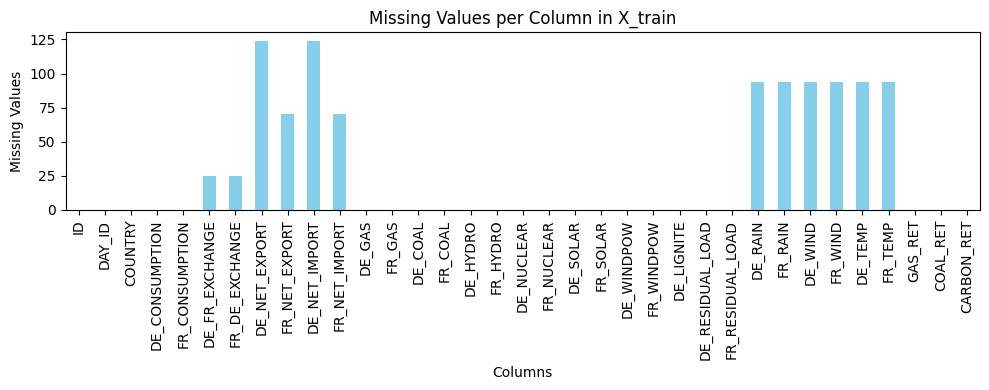

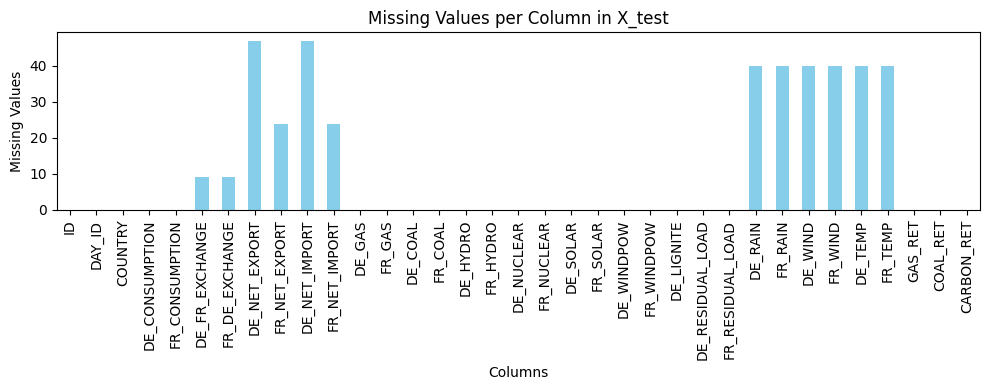

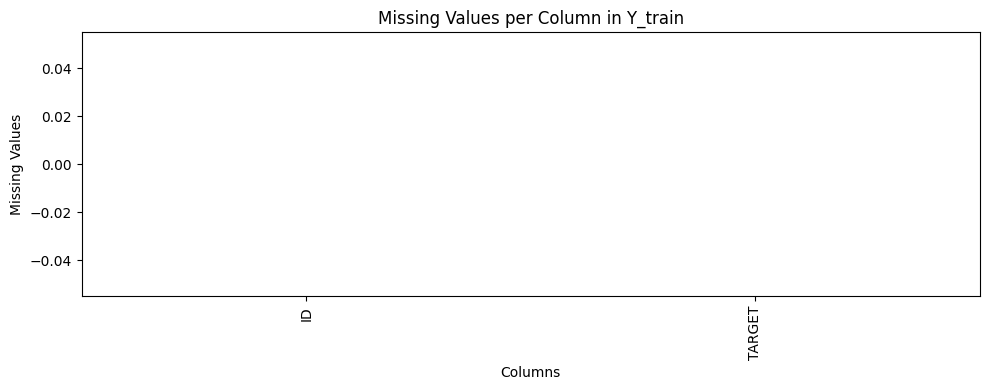

In [6]:
myDataCleaner = DataCleaner(X_train_original, y_train_original, X_test_final)
myDataCleaner.display_missing_data()

In [7]:
myDataCleaner.fill_missing(method="iterative")
myDataCleaner.check_filled_data(method="iterative")

✅ Missing values filled using method: iterative, categorical columns kept at the end: ['ID', 'DAY_ID', 'COUNTRY']
✅ Missing values filled using method: iterative, categorical columns kept at the end: []
RMSE total pour la méthode 'iterative': 0.2633


(np.float64(0.263324660436107),
 {'DE_CONSUMPTION': 0.021518223598137348,
  'FR_CONSUMPTION': 0.01897706630233878,
  'DE_FR_EXCHANGE': 0.045625366827710644,
  'FR_DE_EXCHANGE': 0.046217904065441615,
  'DE_NET_EXPORT': 0.04196557810125961,
  'FR_NET_EXPORT': 0.08693000298741632,
  'DE_NET_IMPORT': 0.0439504365294505,
  'FR_NET_IMPORT': 0.06873535108543304,
  'DE_GAS': 0.1499444300887125,
  'FR_GAS': 0.1146583519098008,
  'DE_COAL': 0.13187978085434454,
  'FR_COAL': 0.10128952156665023,
  'DE_HYDRO': 0.827173594525423,
  'FR_HYDRO': 0.30650734802061064,
  'DE_NUCLEAR': 0.24253909788232936,
  'FR_NUCLEAR': 0.03873922421127203,
  'DE_SOLAR': 0.08863793081992216,
  'FR_SOLAR': 0.15873082759034057,
  'DE_WINDPOW': 0.018519627876328652,
  'FR_WINDPOW': 0.0921299591720455,
  'DE_LIGNITE': 0.1768717100309774,
  'DE_RESIDUAL_LOAD': 0.011989250066056258,
  'FR_RESIDUAL_LOAD': 0.017992807046120385,
  'DE_RAIN': 0.6489676993469657,
  'FR_RAIN': 1.1206844610667235,
  'DE_WIND': 0.1395674924726468,
 

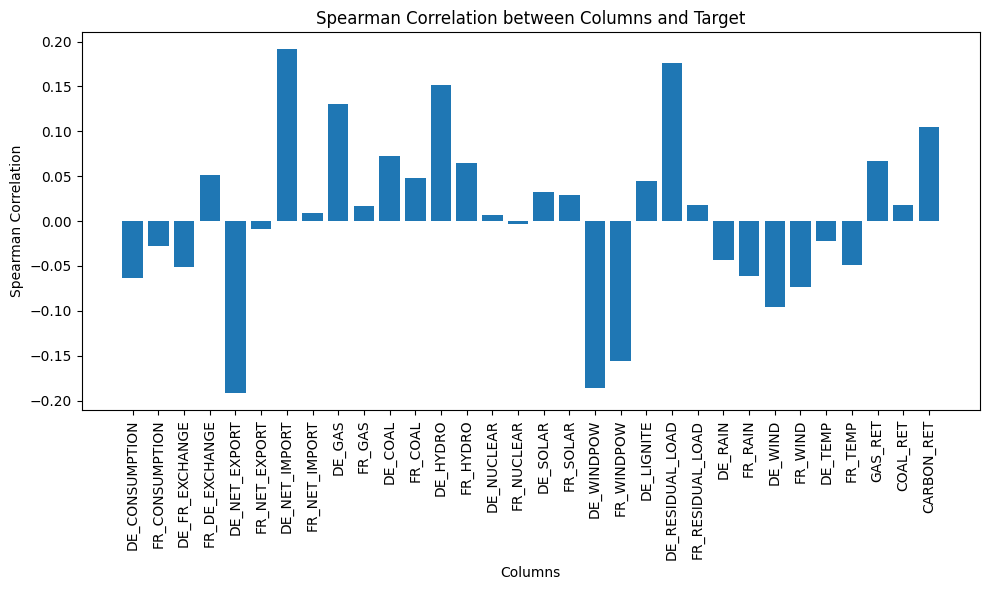

✅ Columns to drop: ['FR_NET_EXPORT', 'FR_NET_IMPORT', 'FR_GAS', 'DE_NUCLEAR', 'FR_NUCLEAR', 'FR_RESIDUAL_LOAD', 'DE_TEMP', 'COAL_RET']


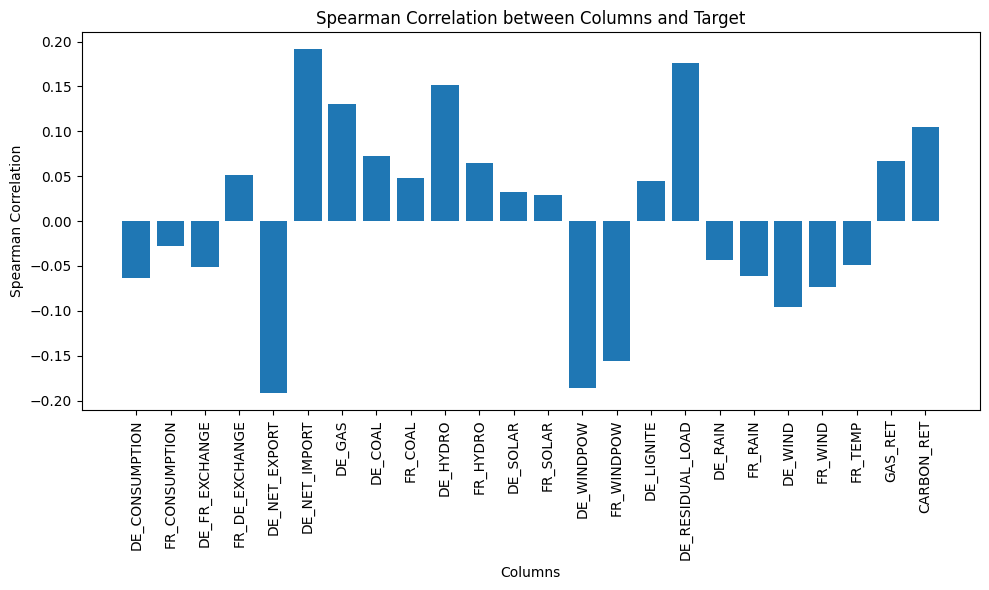

In [8]:
myDataCleaner.drop_Low_Correlation_Columns(threshold=0.025)

# Linear Regression and LASSO

## 1. Linear Regression Principle

**Ordinary Least Squares (OLS) Linear Regression** is a fundamental method used to model the relationship between a scalar dependent variable ($y$) and one or more explanatory variables ($X$). The primary goal is to find the set of coefficients ($\beta$) that minimizes the **Sum of Squared Errors (SSE)**, which is the sum of the squared differences between the observed and predicted values.

The model assumes a linear relationship:
$$
\hat{y}_i = \beta_0 + \sum_{j=1}^{p} X_{i,j} \, \beta_j
$$


The OLS objective function to minimize is:

$$
\min_{\beta} \left\{ \sum_{i=1}^{n} (y_i - \hat{y}_i)^2 \right\}
$$

---


# Regularized Linear Regression Model: Lasso

The **Lasso** (*Least Absolute Shrinkage and Selection Operator*) is a form of linear regression that introduces a penalty term to the classic ordinary least squares cost function.

## The Lasso Cost Function

Lasso minimizes the sum of squared errors while adding an **L1 penalty**, which corresponds to the sum of the absolute values of the coefficients $\beta_j$:

$$
\min_{\beta} \left\{ \sum_{i=1}^{n} (y_i - \hat{y}_i)^2 + \alpha \sum_{j=1}^{p} |\beta_j| \right\}
$$

Where:
- $\alpha$ ($\alpha \ge 0$) is the regularization parameter (the hyperparameter to be optimized).
- $\sum_{j=1}^{p} |\beta_j|$ is the **L1 penalty**.

The **L1 Penalty** has the property of being able to set the coefficients ($\beta_j$) of certain variables to **exactly zero**. Lasso thus performs both regression and automatic **feature selection**.

---

## The Crucial Need for Feature Standardization

For Lasso to perform **fair and effective** variable selection, all features ($\mathbf{X}$) must be on the same scale (standardized, typically $\mu \approx 0$ and $\sigma \approx 1$).

- **Scaling Problem:** If features have different scales (e.g., Feature A ranges from 0 to 1, Feature B from 0 to 1,000), the model is forced to assign a very small coefficient to Feature B and a large one to Feature A just to compensate for the magnitude difference.
- **Penalty Bias:** The L1 penalty applies to the magnitude of $|\beta|$. Without standardization, it would heavily penalize the naturally larger coefficients, thereby **biasing the variable selection**.

**Standardization** ensures that the penalty $\alpha$ is applied **equitably** to all coefficients, ensuring the coefficient set to zero is truly the least relevant one.

---

## Preventing Data Leakage with the Pipeline

The standardization step must be performed **correctly** during Cross-Validation (CV) to avoid **Data Leakage**:

1.  **The Risk (Data Leakage):** If we standardize the entire $X_{\text{train}}$ set at once before the CV, the statistics ($\mu$ and $\sigma$) are calculated using data from the future **Validation** set. The model is tested on data whose distribution it has indirectly seen, leading to an **overestimated and biased** CV score.

2.  **The Solution (Pipeline)
:** We use a `Pipeline` (\`scikit-learn\`) that encapsulates the `StandardScaler` and the `Lasso`. For each CV fold:
    - The `StandardScaler` **learns** ($\mu$ and $\sigma$) **only** on the **Training** data for that fold.
    - It then **applies** that learned transformation to the **Validation** data for scoring.

The **Pipeline** ensures the evaluation is **honest** and accurately reflects the model's ability to generalize to new, unseen data.

In [29]:

class LassoModel:
    """
    Régression Lasso (L1),
    avec standardisation dans un Pipeline pour la Cross-Validation (GridSearchCV).
    """
    def __init__(self, X_train, Y_train, X_test_final, test_size=0.1, random_state=42, cat_features=None):

        self.X_train_original = X_train.copy()
        # Y_train : on ne garde que Target
        if isinstance(Y_train, pd.DataFrame) and 'TARGET' in Y_train.columns:
            self.y_train_original = Y_train['TARGET'].copy()
        else:
            # Series/vecteur avec un nom
            self.y_train_original = Y_train.copy()
            if isinstance(self.y_train_original, pd.Series) and self.y_train_original.name is None:
                self.y_train_original.name = 'TARGET'

        self.X_test_final = X_test_final.copy()
        self.X_test_final_original = X_test_final.copy() # pour garder la colonne ID pour la soumission
        self.cat_features = cat_features or []

        # Colonnes à ignorer lor sde l entraînement du modèle
        # variables catégorielles
        self.columns_to_drop_for_model = ['ID', 'COUNTRY', 'DAY_ID']

        # --- data set engineering for training  ---
        self.X_train_processed = self.X_train_original.drop(columns=[c for c in self.columns_to_drop_for_model if c in self.X_train_original.columns], errors='ignore')
        self.X_test_processed = self.X_test_final.drop(columns=[c for c in self.columns_to_drop_for_model if c in self.X_test_final.columns], errors='ignore')

        # --- noms des cols numériques pour la standardisation ---
        self.numeric_cols = self.X_train_processed.select_dtypes(include=np.number).columns.tolist()


        # --- params de la classe ---
        self.test_size = test_size
        self.random_state = random_state
        self.cv_folds = 5 # Valeur par défaut pour la CV

        # --- resultats ---
        self.model_pipeline = None # Le meilleur estimateur sera le Pipeline complet
        self.best_params = None
        self.mse_train_cv = None
        self.mse_test = None
        self.spearman_train_cv = None

        # --- internal datasets (split train/test sur processed data) ---
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None

    # --- getters --- (La plupart sont conservés pour la cohérence)
    def get_X_train_original(self): return self.X_train_original
    def get_y_train_original(self): return self.y_train_original
    def get_X_test_final(self): return self.X_test_final
    def get_cat_features(self): return self.cat_features
    def get_test_size(self): return self.test_size
    def get_random_state(self): return self.random_state
    def get_mse_train_cv(self): return self.mse_train_cv
    def get_mse_test(self): return self.mse_test
    def get_spearman_train_cv(self): return self.spearman_train_cv
    def get_X_train(self): return self.X_train
    def get_X_test(self): return self.X_test
    def get_y_train(self): return self.y_train
    def get_y_test(self): return self.y_test
    def get_model(self):
        if self.model_pipeline is None:
            print("No model has been trained yet. Call .fit() first.")
        return self.model_pipeline
    def get_best_params(self):
        if self.best_params is None:
            print("No best parameters found yet. Run .fit() first.")
        return self.best_params

    def fit(self, param_grid=None, cv=5):
        """
        Entraîne le modèle Lasso avec standardisation dans un Pipeline et optimisation alpha.
        """
        self.cv_folds = cv

        # 1 - Séparation Train/Validation (sur les données traitées)
        # Le split doit se faire après avoir retiré les colonnes non pertinentes
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.X_train_processed, self.y_train_original, test_size=self.test_size, random_state=self.random_state
        )
        self.y_train = self.y_train.values.ravel()
        self.y_test = self.y_test.values.ravel()

        # 2. Définition du Pipeline (Standardisation -> Lasso)

        # operation de pre traitement : Strandard scaler aux cols numeriques
        preprocessor = ColumnTransformer(
            transformers=[
                ('standardize', StandardScaler(), self.numeric_cols)
            ],
            # standardize : nom de l operation
            # StandardScaler : operateur, calcule mu, sigma et change l echelle
            # numeric cols : cols auxquelles on applique
            remainder='passthrough' # si il reste des cols categorielles : on les laisse intact
        )

        #  construction du modele ( sera appele dans la recherche de alpha)
        lasso_pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            # 1 - on transforme les donees

            # 2 - on applique LASSO
            # Utilisation de max_iter élevé car Lasso converge lentement sur certaines données
            ('regressor', Lasso(random_state=self.random_state, max_iter=10000))
        ])

        # 3 - params de grid search
        if param_grid is None:
            # La grille cible l'hyperparamètre 'alpha' DANS l'étape 'regressor' du Pipeline
            # 50 valeurs différentes pour alpha dans l'intervalle 0.00001, 1.0
            # echelle logarithmique : log space
            param_grid = {'regressor__alpha': np.logspace(-5, 0, 50)}

        # 4. inti +  GridSearch
        grid_search = GridSearchCV(
            estimator=lasso_pipeline,
            param_grid=param_grid,
            cv=cv,
            scoring='neg_mean_squared_error',
            return_train_score=False,
            n_jobs=-1,
            verbose=1
        )

        # lancement de la recherche de alpha avec gridsearch de sklearn
        print("Lancement de la recherche d'hyperparamètres pour Lasso (avec Standardisation)...")
        grid_search.fit(self.X_train, self.y_train)

        # 5. Enregistrer les résultats
        self.best_params = grid_search.best_params_
        self.model_pipeline = grid_search.best_estimator_ # Le meilleur estimateur est le Pipeline

        # MSE du meilleur modèle sur les k folds
        self.mse_train_cv = -1 * grid_search.best_score_

        # 6. Corrélation de Spearman (sur les prédictions CV hors-pli)
        # cross val predict : de sklearn, permet de predire le dataset avec validation croisee, sans fuite de donnees
        y_pred_train_cv = cross_val_predict(self.model_pipeline, self.X_train, self.y_train, cv=cv, n_jobs=-1)
        self.spearman_train_cv = spearmanr(y_pred_train_cv, self.y_train).correlation * 100

        # 7. Évaluation sur le jeu de Validation/Test (interne)
        y_pred_test = self.model_pipeline.predict(self.X_test)
        self.mse_test = mean_squared_error(self.y_test, y_pred_test)

        # 8. Affichage des résultats
        print("\n" + "="*50)
        print("✅Entraînement Lasso Terminé")
        # Les paramètres renvoyés sont formatés 'regressor__alpha'
        print("Best parameters found: ", self.best_params)
        print(f"Best MSE (train CV): {self.mse_train_cv:.4f}")
        print(f"Spearman correlation (train CV): {self.spearman_train_cv:.2f}%")
        print(f"MSE on internal test data: {self.mse_test:.4f}")
        print("="*50 + "\n")


    def predict(self, X_new=None, save_submission=False, submission_path='Lasso_submission.csv'):
        """
        Fait des prédictions sur le jeu X_test_final pour la soumission.
        """
        if self.model_pipeline is None:
            raise ValueError("Model not trained yet. Call fit() first.")

        # X_new est le jeu X_test_final (données traitées) par défaut
        if X_new is None:
            X_new = self.X_test_processed

        # Le Pipeline attend les colonnes que le ColumnTransformer a vues
        # Assurer l'alignement des colonnes (même si les IDs ont été retirées)
        X_new_aligned = X_new[[col for col in self.X_train_processed.columns if col in X_new.columns]]


        y_pred = self.model_pipeline.predict(X_new_aligned) # Le Pipeline applique la standardisation


        if save_submission:
            # Utilisation de X_test_final_original pour récupérer les IDs
            if 'ID' in self.X_test_final_original.columns:
                submission = self.X_test_final_original[['ID']].copy()
            else:
                print("No 'ID' column found in X_test_final_original. Cannot create submission file with IDs.")
                return y_pred # Retourne seulement les prédictions

            submission['TARGET'] = y_pred
            submission.to_csv(submission_path, index=False)
            print(f"✅ Submission file saved to: {submission_path}")

        return y_pred


    def evaluate(self, X_eval = None, y_eval = None):
        """Calcule le MSE et la corrélation de Spearman sur un jeu de données donné (par défaut, X_test interne)."""
        if self.model_pipeline is None:
            raise ValueError("Model not trained yet. Call fit() first.")

        if (X_eval is None) and (y_eval is None):
            X_eval = self.X_test
            y_eval = self.y_test

        # Le jeu d'évaluation doit être aligné sur les colonnes d'entraînement traitées
        X_eval_aligned = X_eval[[col for col in self.X_train_processed.columns if col in X_eval.columns]]

        y_pred = self.model_pipeline.predict(X_eval_aligned)

        # S'assurer que y_eval est un tableau numpy
        if hasattr(y_eval, 'values'):
             y_eval = y_eval.values.ravel()

        if len(y_eval) != len(y_pred):
             raise ValueError(f"Inconsistent number of samples: y_eval has {len(y_eval)} samples, but y_pred has {len(y_pred)}.")

        mse = mean_squared_error(y_eval, y_pred)
        spearman = spearmanr(y_pred, y_eval).correlation * 100
        print(f"MSE on evaluation data: {mse:.4f}")
        print(f"Spearman correlation on evaluation data: {spearman:.2f}%")
        return mse, spearman

    def plot_spearman_rank_scatter(self, title_suffix=""):
        """
         nuage de points des rangs : pr voir  la corrélation monotone (Spearman)
        entre : prédictions du modèle / vraies valeurs sur X_train et X test interns.
        """
        if self.model_pipeline is None:
            print("Erreur : Le modèle n'a pas été entraîné. Veuillez appeler .fit() d'abord.")
            return

        if self.X_test is None or self.y_test is None:
            print("Erreur : Le split Train/Test n'a pas été effectué. Veuillez appeler .fit() d'abord.")
            return

        # 1. preds sur le jeu de validation interne
        y_pred_test = self.model_pipeline.predict(self.X_test)

        # 2. Calcul des rangs
        # rankdata attribue un rang à chaque valeur. 'average'='average' gère les ex aequo.
        ranks_y_test = rankdata(self.y_test)
        ranks_y_pred = rankdata(y_pred_test)

        # 3. Calcul du coefficient de Spearman pour le titre (si déjà fait, on réutilise)
        spearman_score = self.evaluate(self.X_test, self.y_test)[1]

        # 4. Création du graphique
        plt.figure(figsize=(8, 8))

        # Tracer le nuage de points des rangs
        sns.scatterplot(x=ranks_y_pred, y=ranks_y_test, alpha=0.5, s=15)

        # Tracer la ligne d'identité (y=x) comme référence de la relation parfaite
        max_rank = len(ranks_y_test)
        plt.plot([0, max_rank], [0, max_rank], color='red', linestyle='--', alpha=0.7, label='Corrélation Parfaite rho=1)')

        # Titre
        full_title = f"Corrélation de Spearman des Rangs (Validation Interne) rho = {spearman_score:.2f} {title_suffix}"
        plt.title(full_title, fontsize=12)

        plt.xlabel("Rang des Prédictions avec Lasso de Y", fontsize=11)
        plt.ylabel("Rang des Vraies Valeurs de Y", fontsize=11)
        plt.grid(True, linestyle=':', alpha=0.5)
        plt.legend()
        plt.show()

    def save_model(self) :
      if (self.model_pipeline is None) :
        raise ValueError("Model not trained yet. Call fit() first.")
      joblib.dump(self.model_pipeline, "my_full_Lasso_model.pkl")

In [30]:
myLassoModel = LassoModel(myDataCleaner.get_X_train(), myDataCleaner.get_Y_train(), myDataCleaner.get_X_test_final())
myLassoModel.fit(param_grid=None, cv=5)

Lancement de la recherche d'hyperparamètres pour Lasso (avec Standardisation)...
Fitting 5 folds for each of 50 candidates, totalling 250 fits

✅Entraînement Lasso Terminé
Best parameters found:  {'regressor__alpha': np.float64(0.014563484775012445)}
Best MSE (train CV): 1.0484
Spearman correlation (train CV): 22.52%
MSE on internal test data: 0.9784



MSE on evaluation data: 0.9784
Spearman correlation on evaluation data: 19.62%
MSE on evaluation data: 0.9784
Spearman correlation on evaluation data: 19.62%


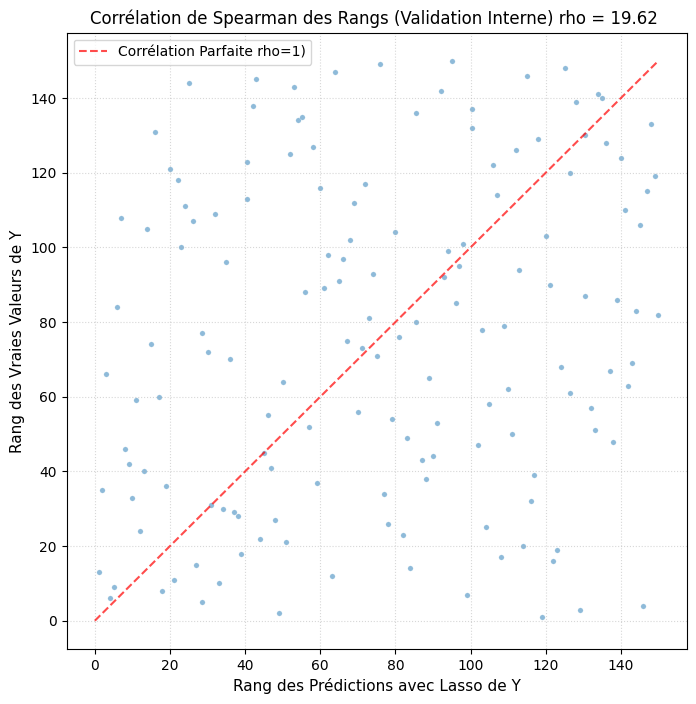

In [31]:
myLassoModel.evaluate()
myLassoModel.plot_spearman_rank_scatter()

Vérification de la cohérence linéaire pour les modèles de régression (Lasso/Ridge)...


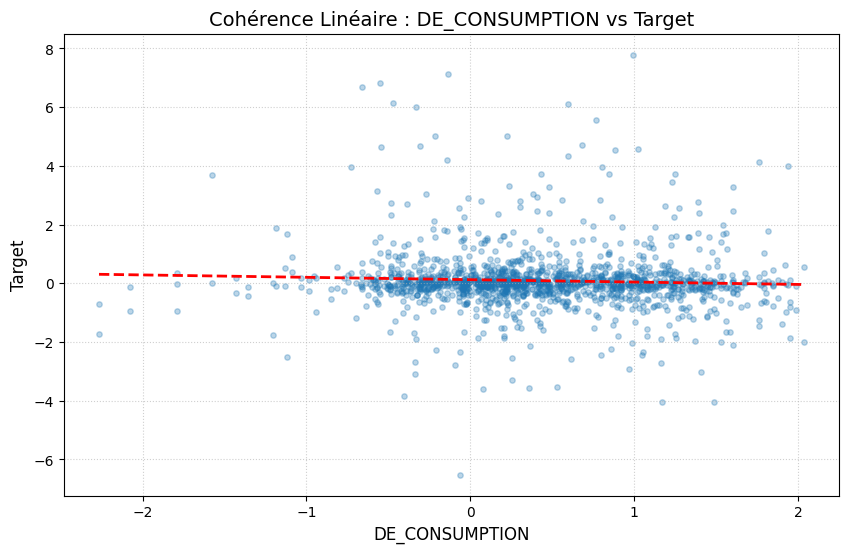

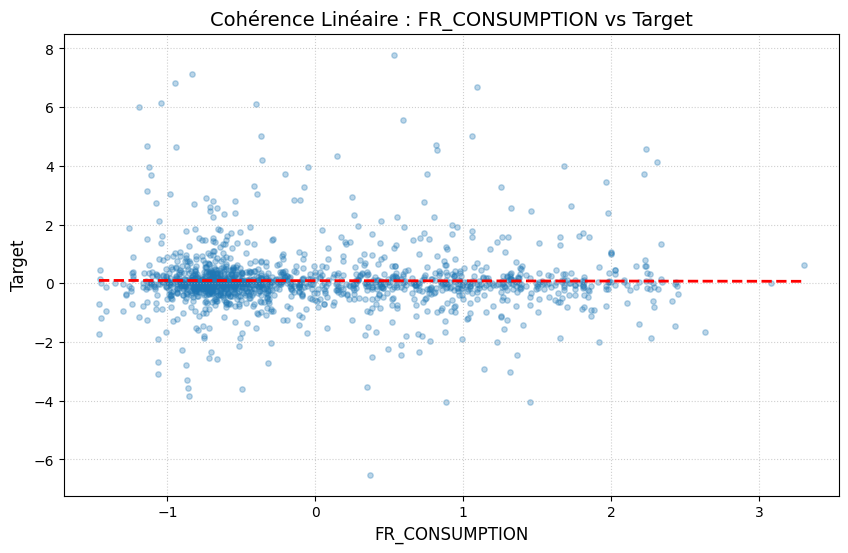

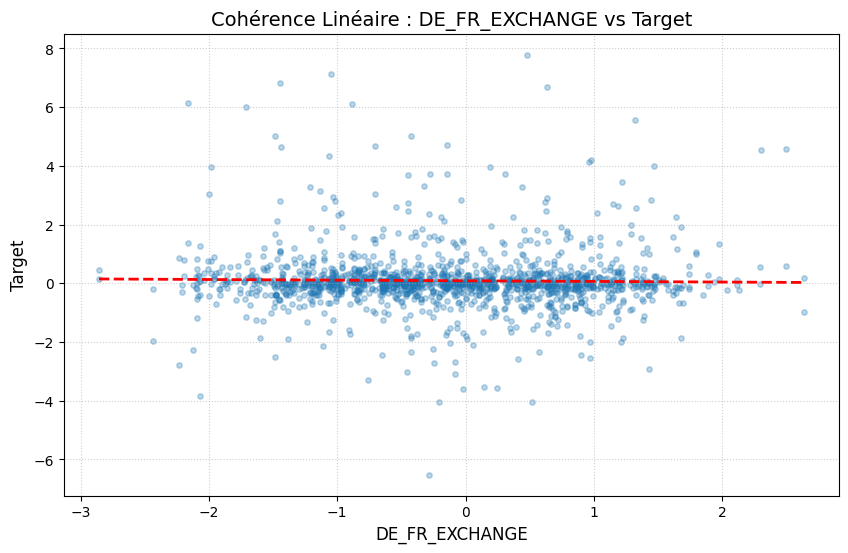

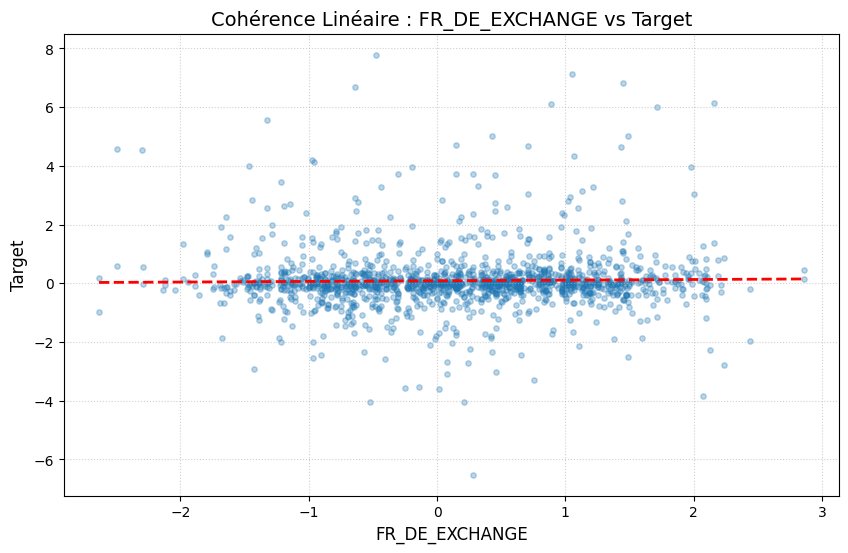

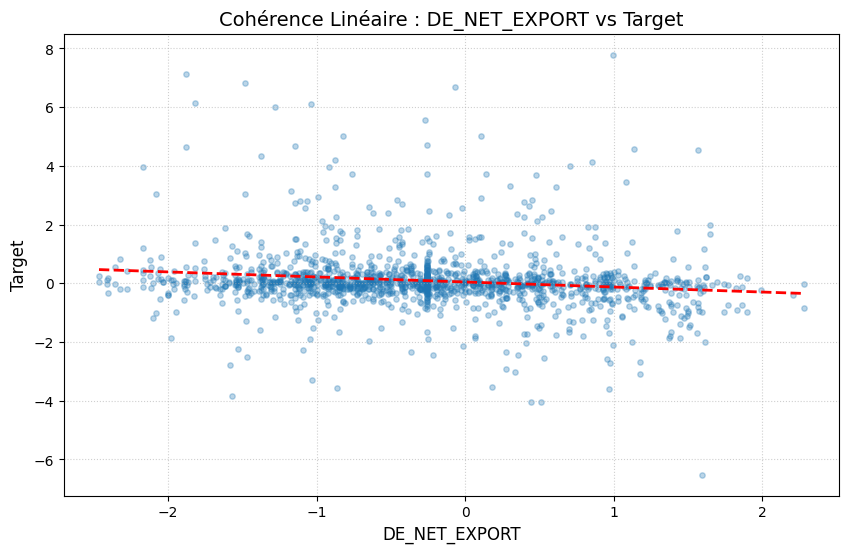

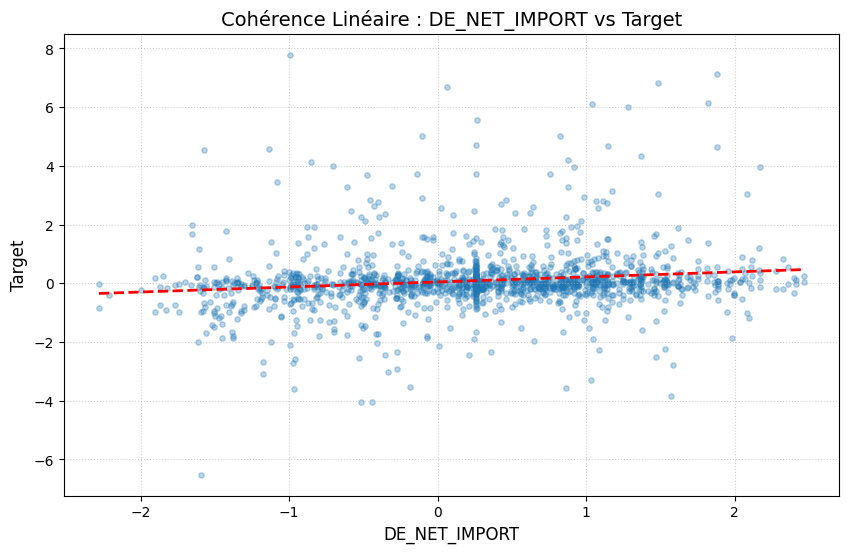

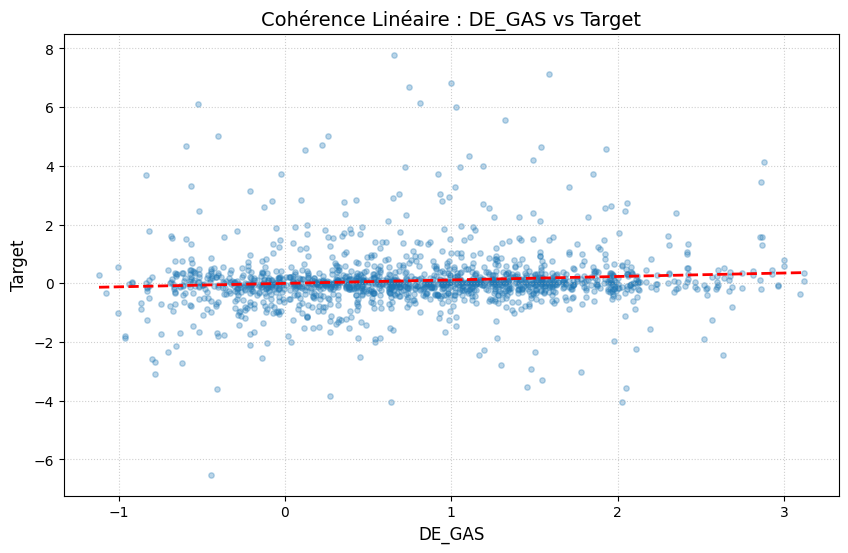

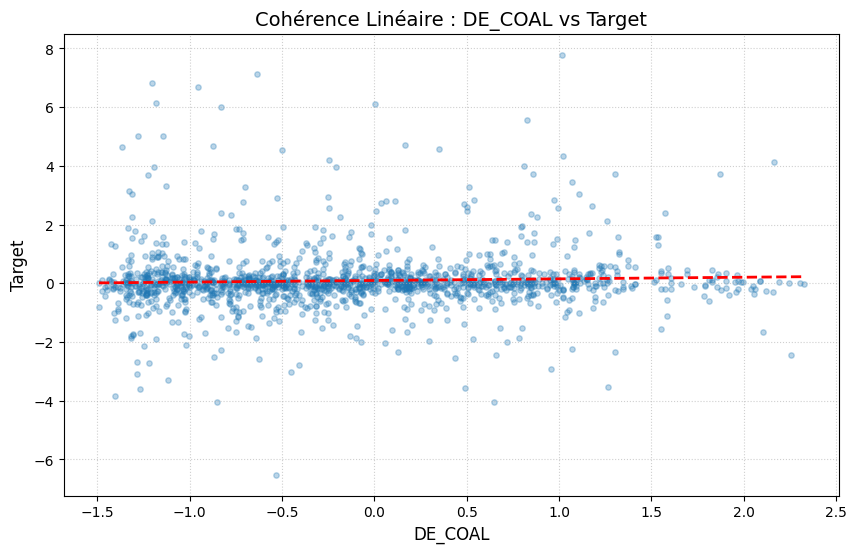

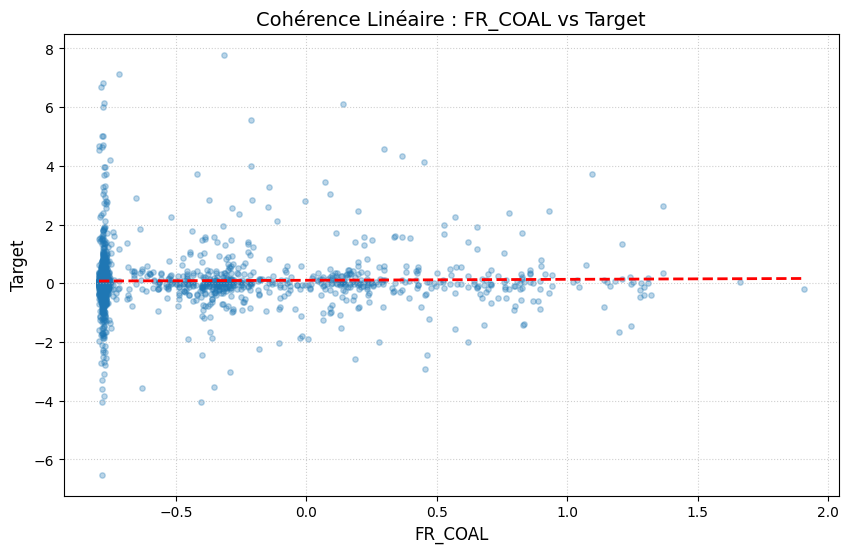

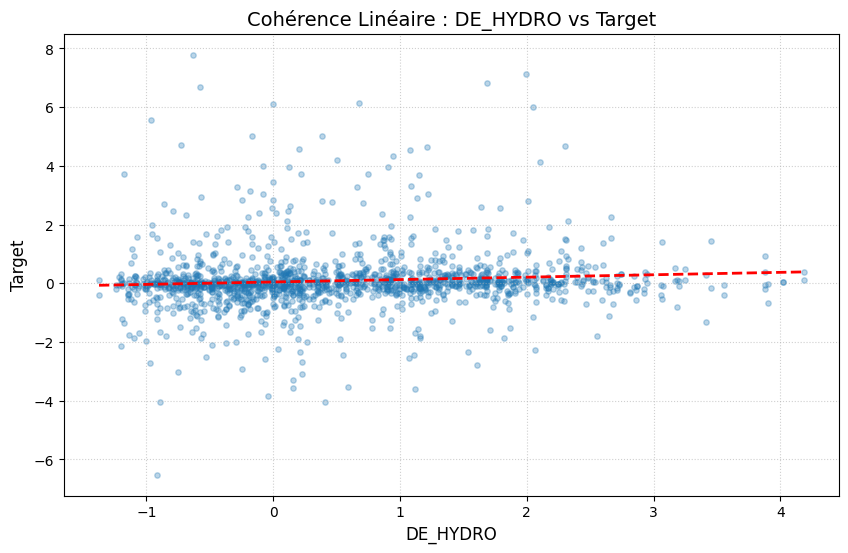

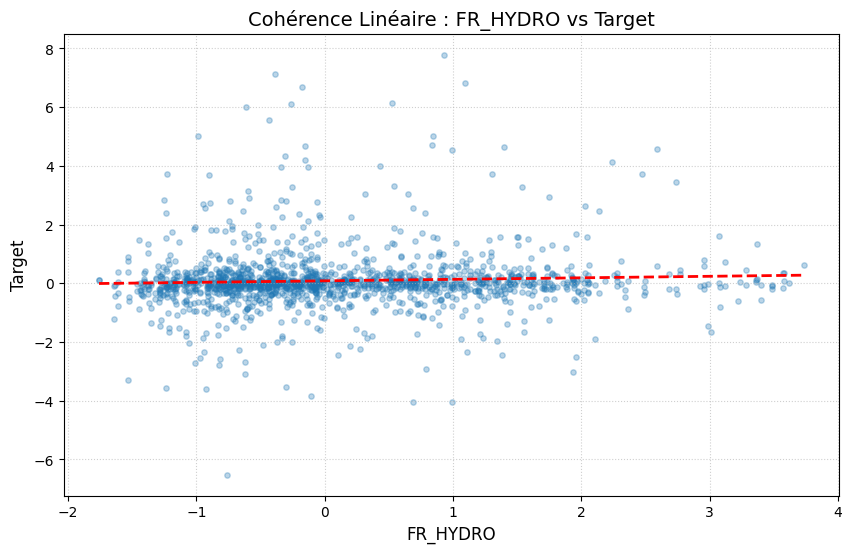

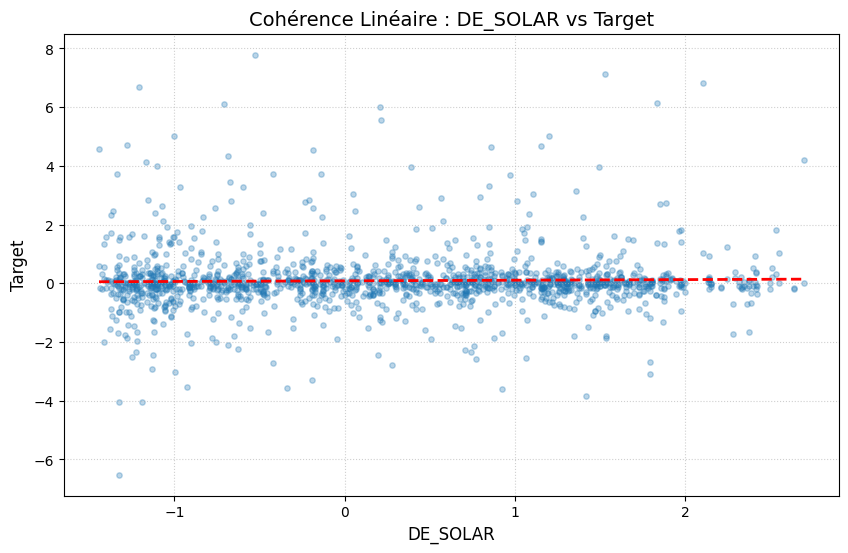

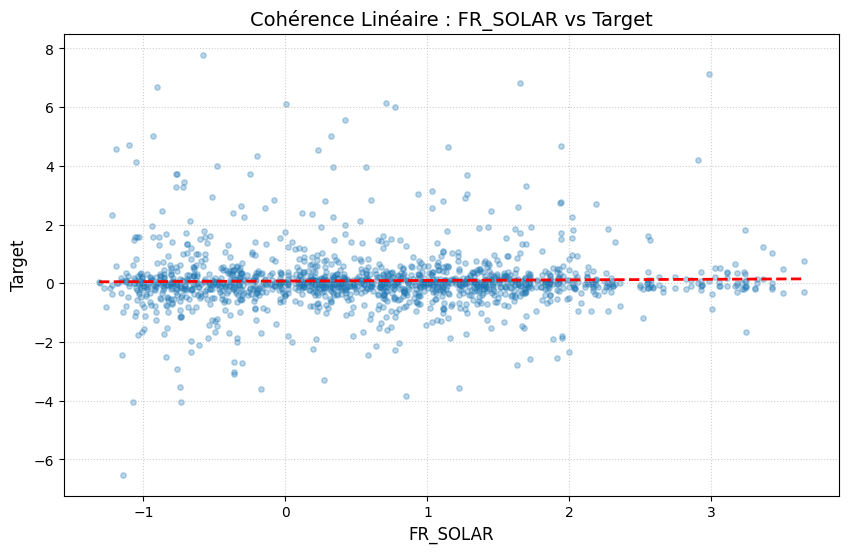

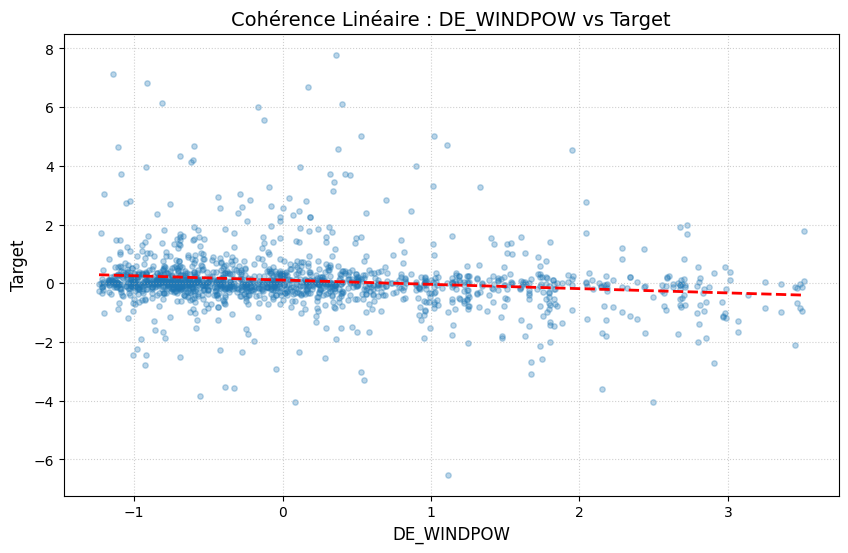

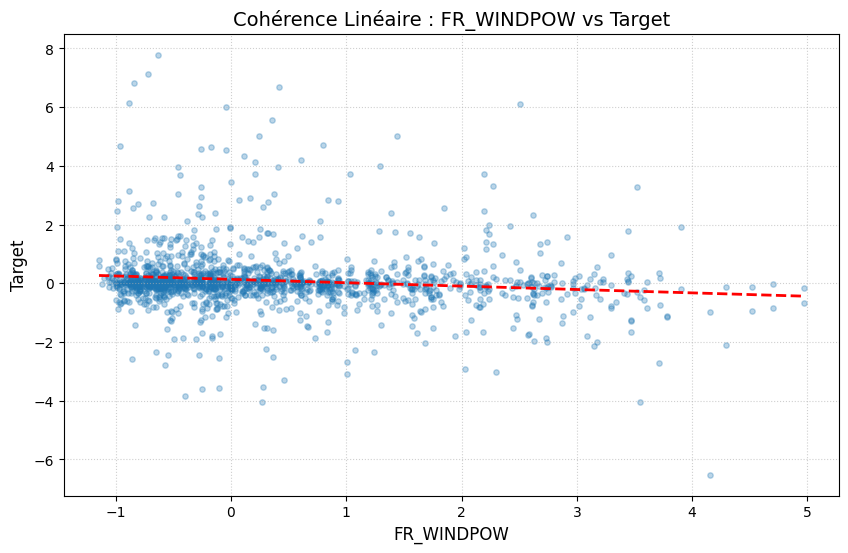

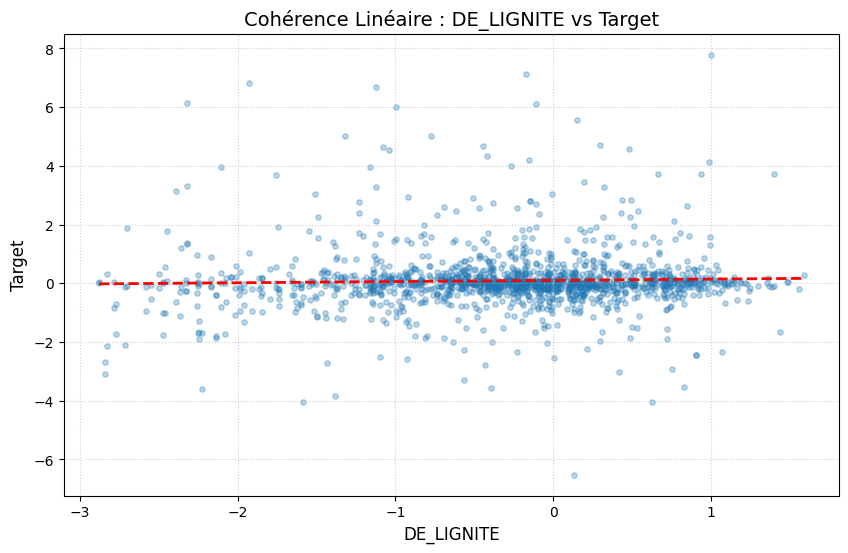

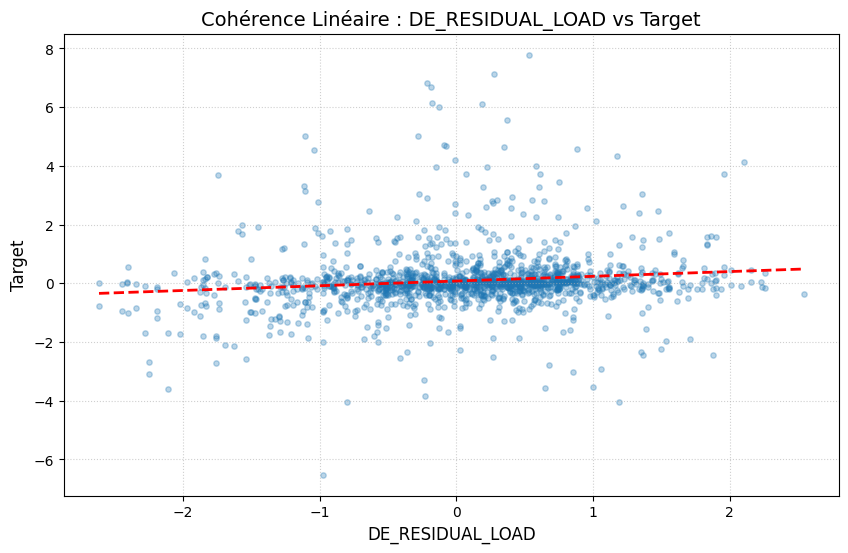

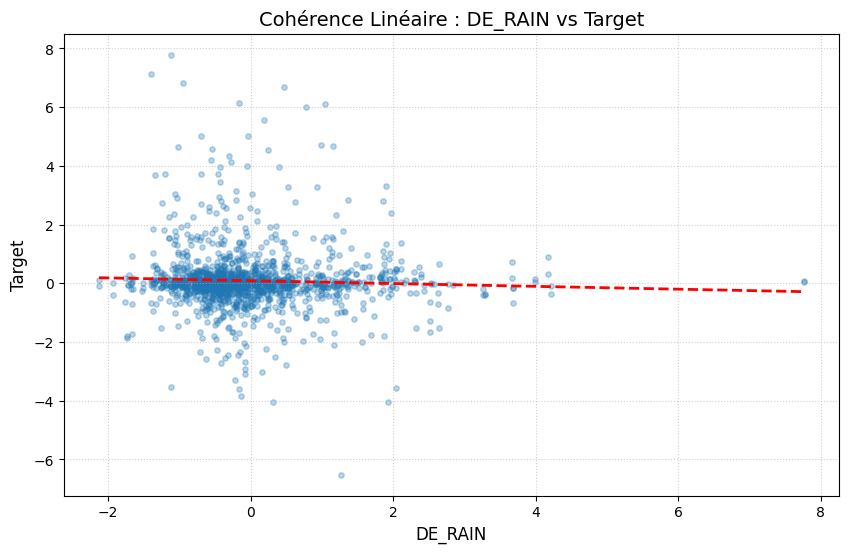

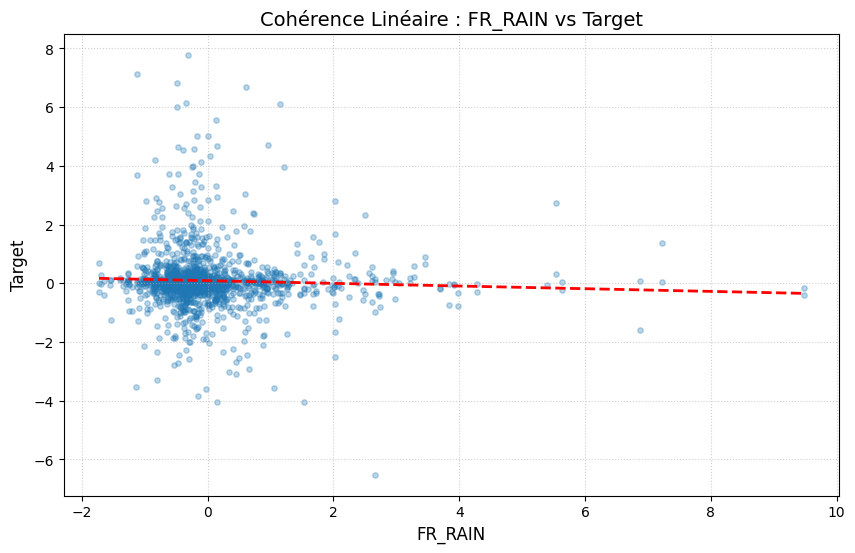

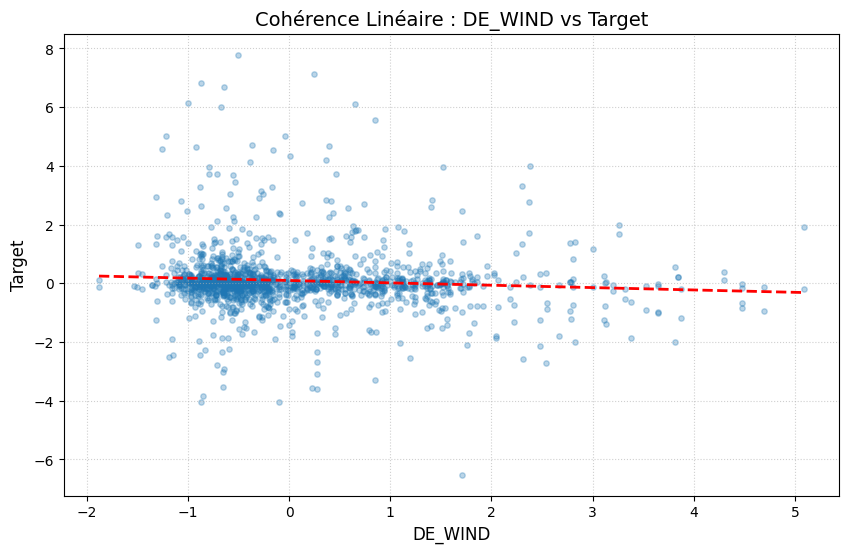

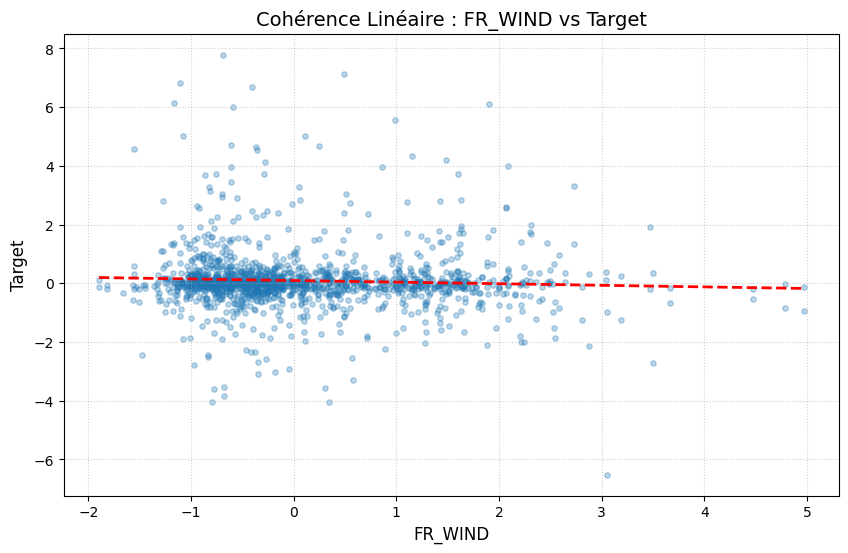

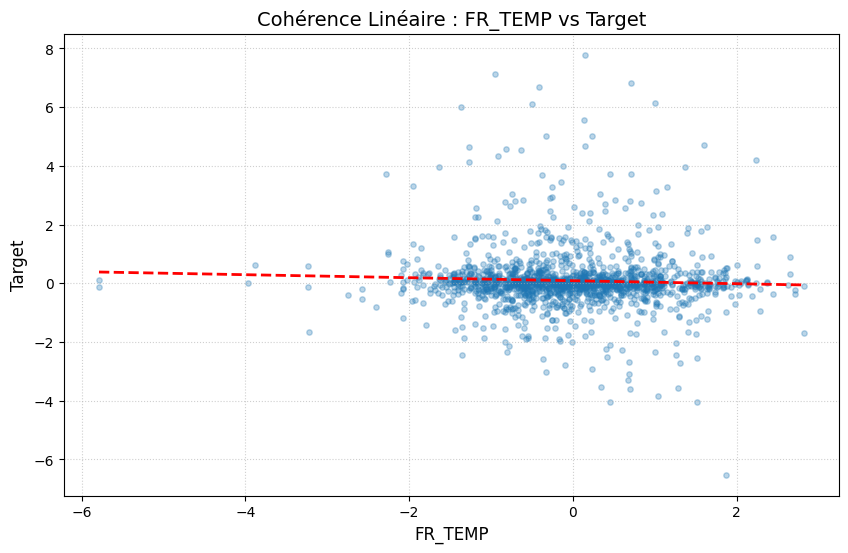

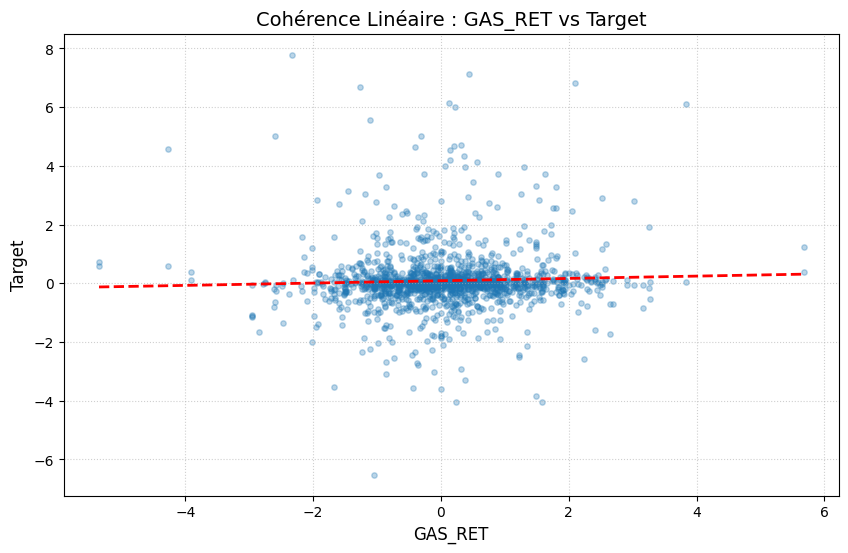

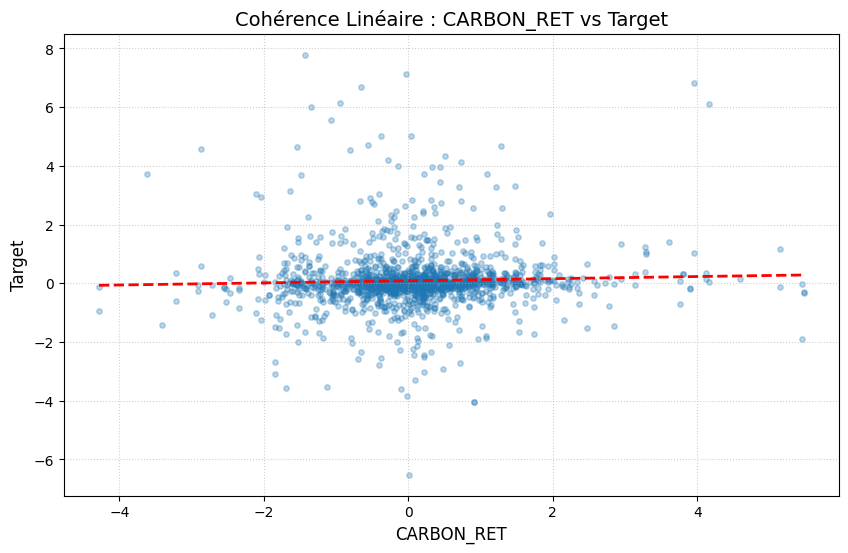

In [32]:
"""
Résultat qui laisse une marge d'amélioration,
effectivement pour LASSO on fait des hyps sur les lois de target en fonction des variables qui ne sont pas vérifiées ici
"""
myDataCleaner.plot_linear_coherence()